# TensorFlow

Logistic regression (with SGD) and {1,2}D neural network on the notMNIST data

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,classification_report,f1_score
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from IPython.display import Image
import tensorflow as tf

%matplotlib inline

In [5]:
pick = pickle.load(open('/Users/gautamborgohain/PycharmProjects/tensorflow-master/tensorflow/examples/udacity/notMNIST.pickle','rb'))
train_dataset = pick.get('train_dataset')
test_dataset =pick.get('test_dataset')
train_labels = pick.get('train_labels')
test_labels = pick.get('test_labels')
valid_dataset = pick.get('valid_dataset')
valid_labels = pick.get('valid_labels')
print(len(train_dataset))
print(len(test_dataset))

del pick

200000
10000


----
# Of the shelf Logistic Regression
----

In [ ]:
''' Data reshape to 2D'''
train_dataset = np.reshape(train_dataset,(len(train_dataset),784)) 
test_dataset = np.reshape(test_dataset,(len(test_dataset),784)) 
valid_dataset = np.reshape(valid_dataset,(len(valid_dataset),784)) 

In [9]:
clf = LogisticRegression()
clf.fit(train_dataset[0:5000],train_labels[0:5000])

val_pred = clf.predict(valid_dataset)
print(accuracy_score(valid_labels,val_pred))

test_pred = clf.predict(test_dataset)
print(accuracy_score(test_labels,test_pred))

0.7863
0.8507


---
# Multinomial Logistic regression with Gradient descent
---


In [26]:
''' Labels binarized'''
train_labels= LabelBinarizer().fit_transform(X = train_labels).astype(np.float32)
test_labels= LabelBinarizer().fit_transform(X = test_labels).astype(np.float32)
valid_labels= LabelBinarizer().fit_transform(X = valid_labels).astype(np.float32)

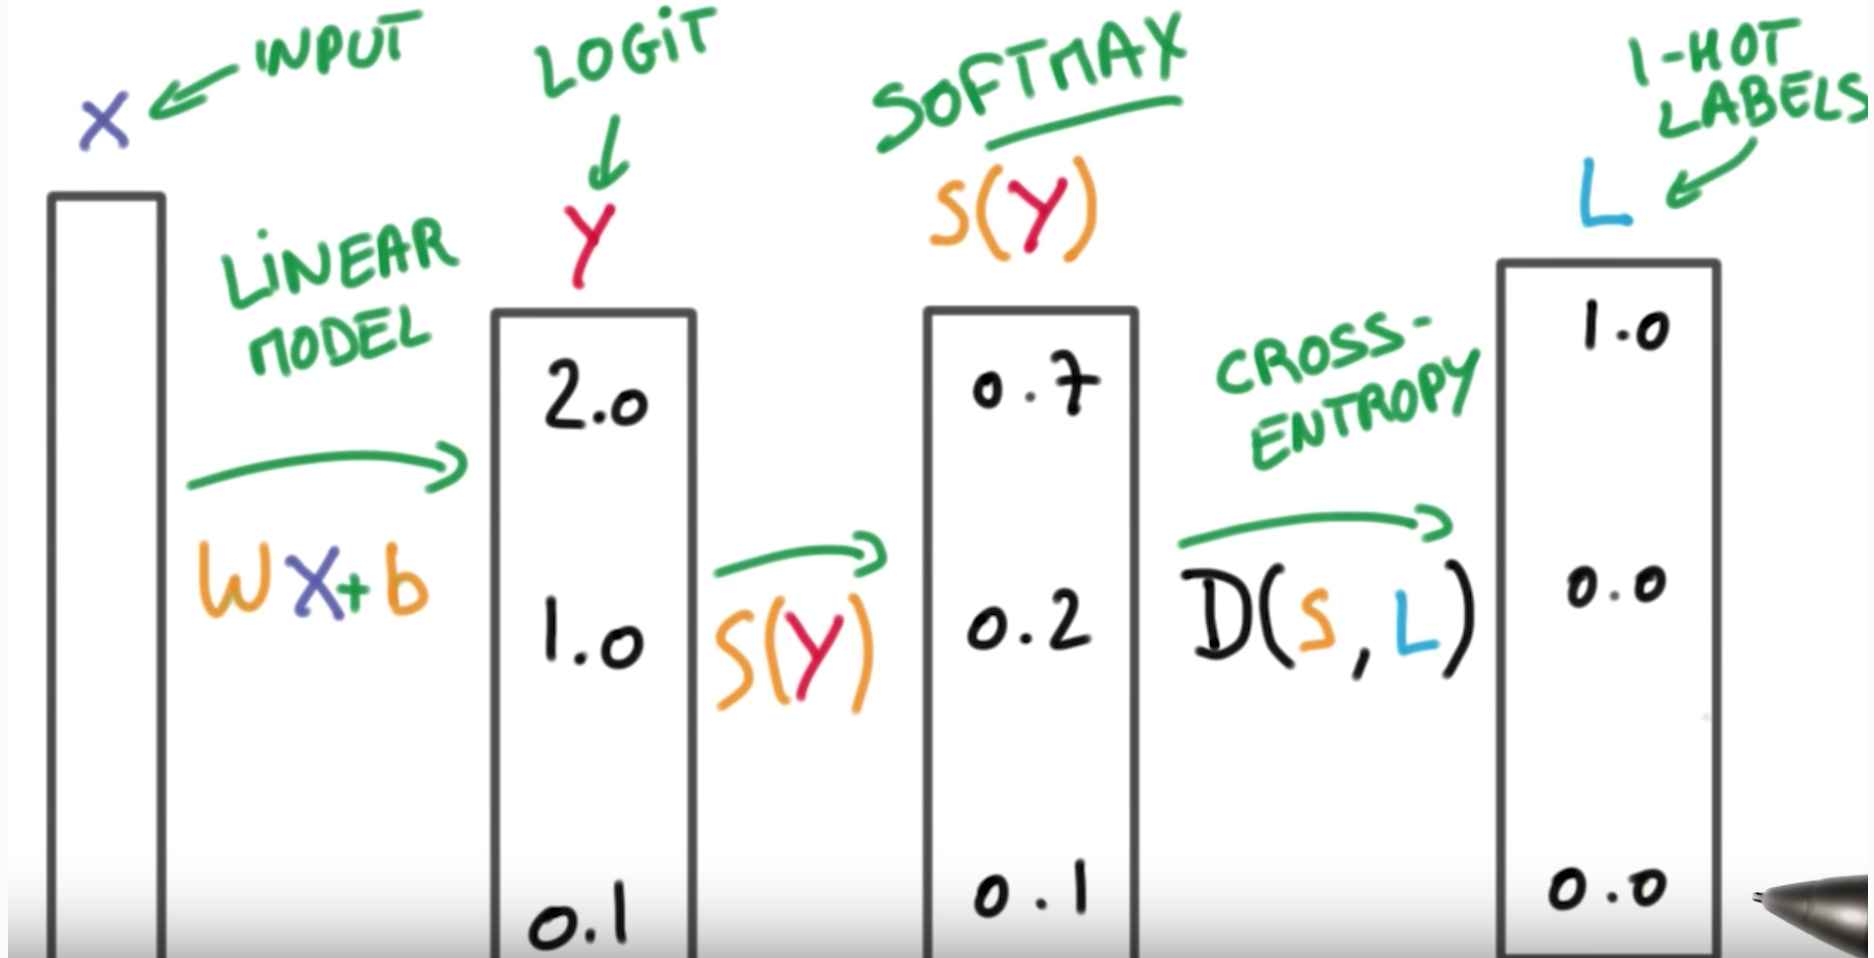

In [15]:
Image(filename='/Users/gautamborgohain/PycharmProjects/DataScience/Neural Networks/Images/multinomial_logistic.png', retina=True )

---
** Simple Gradient Descent **

---

In [35]:
`
train_sample = 10000
img_size = 28
num_labels = 10

graph = tf.Graph()
with graph.as_default():
    ''' Input Data
        In this section, the datasets are set as constants and the entire dataset is trained at a time- simple gradient descent
    '''
    tf_train_dataset = tf.constant(train_dataset[:train_sample,:])
    tf_train_labels = tf.constant(train_labels[:train_sample])
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    ''' Weights and Biases 
        The weights are initialized in truncated normal distribuiton and the biases are initialized as zeros
        Weights are 784X10 - 784 pixel features foreach image and 10 is the label
        Biases are for the 10 labels
    '''
    weights = tf.Variable(tf.truncated_normal([img_size*img_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' Logits,Loss, Optimizer (trainer)
    Logits are the X.W +b -- Updated as the weigths and the biases are updated by the optimizer
    Loss is the comparision of the probabilities generated from the logits by the softmax , with the labels
    
    '''
    logits = tf.matmul(tf_train_dataset,weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(loss)
    ''' Predictions
    '''
    pr = tf.Print(weights,[weights])
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(tf.matmul(tf_test_dataset,weights) + biases)
    valid_predictions = tf.nn.softmax(tf.matmul(tf_valid_dataset,weights) + biases)

In [43]:
'''
Sklearn accuracy does not support binarized format

'''
def accuracy(labels, predictions):
    return 100*(np.sum(np.argmax(labels,1) == np.argmax(predictions,1)) / predictions.shape[0])

In [54]:
iters = 201

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    for step in range(iters):
        ''' Here the tensors to run are specified, w are the weights that are returned using the tf.Print().
            The training and vaidation predictions are computed after the optimizer and loss are called. SEQUENCE MATTERS
            The tensor can also be run by calling the eval method
        '''
        w,l,_,predictions,val_predictions = session.run([pr,loss,optimizer,training_predictions,valid_predictions])
        if step %100 == 0:
            print('Loss at Step ', step, ' : ', l)
            print('Training Accuracy : ', accuracy(train_labels[:train_sample],predictions))
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Loss at Step  0  :  13.8681
Training Accuracy :  11.05
Validation Accuracy :   11.22
Testing Accuracy :  15.64
Loss at Step  100  :  2.32592
Training Accuracy :  72.16
Validation Accuracy :   71.45
Testing Accuracy :  77.96
Loss at Step  200  :  1.88721
Training Accuracy :  74.95
Validation Accuracy :   73.65
Testing Accuracy :  80.48


---
**Stochastic Gradient Descent**

---

In [56]:
''' Copy of the cell above with the graph
    Everything same except for the input data section -  instead of having constants, we make placeholders for it to keep changing
'''
batch_size = 128
img_size = 28
num_labels = 10

graph = tf.Graph()
with graph.as_default():
    ''' Input Data
        Placeholders for training data and labels
    '''
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    weights = tf.Variable(tf.truncated_normal([img_size*img_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(tf_train_dataset,weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(loss)
    pr = tf.Print(weights,[weights])
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(tf.matmul(tf_test_dataset,weights) + biases)
    valid_predictions = tf.nn.softmax(tf.matmul(tf_valid_dataset,weights) + biases)

In [60]:
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    
    for step in range(iters):
        '''
        Get data in batches
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Dictionary to tell where to find the mini batchs
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        w,l,_,predictions,val_predictions = session.run([pr,loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print('Minibatch Training Accuracy : ', accuracy(batch_labels,predictions))
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  15.4008
Minibatch Training Accuracy :  9.375
Validation Accuracy :   9.37
Testing Accuracy :  10.35
Minibatch Loss at Step  100  :  2.83163
Minibatch Training Accuracy :  68.75
Validation Accuracy :   70.02
Testing Accuracy :  77.54


---
**1D neural network**

---

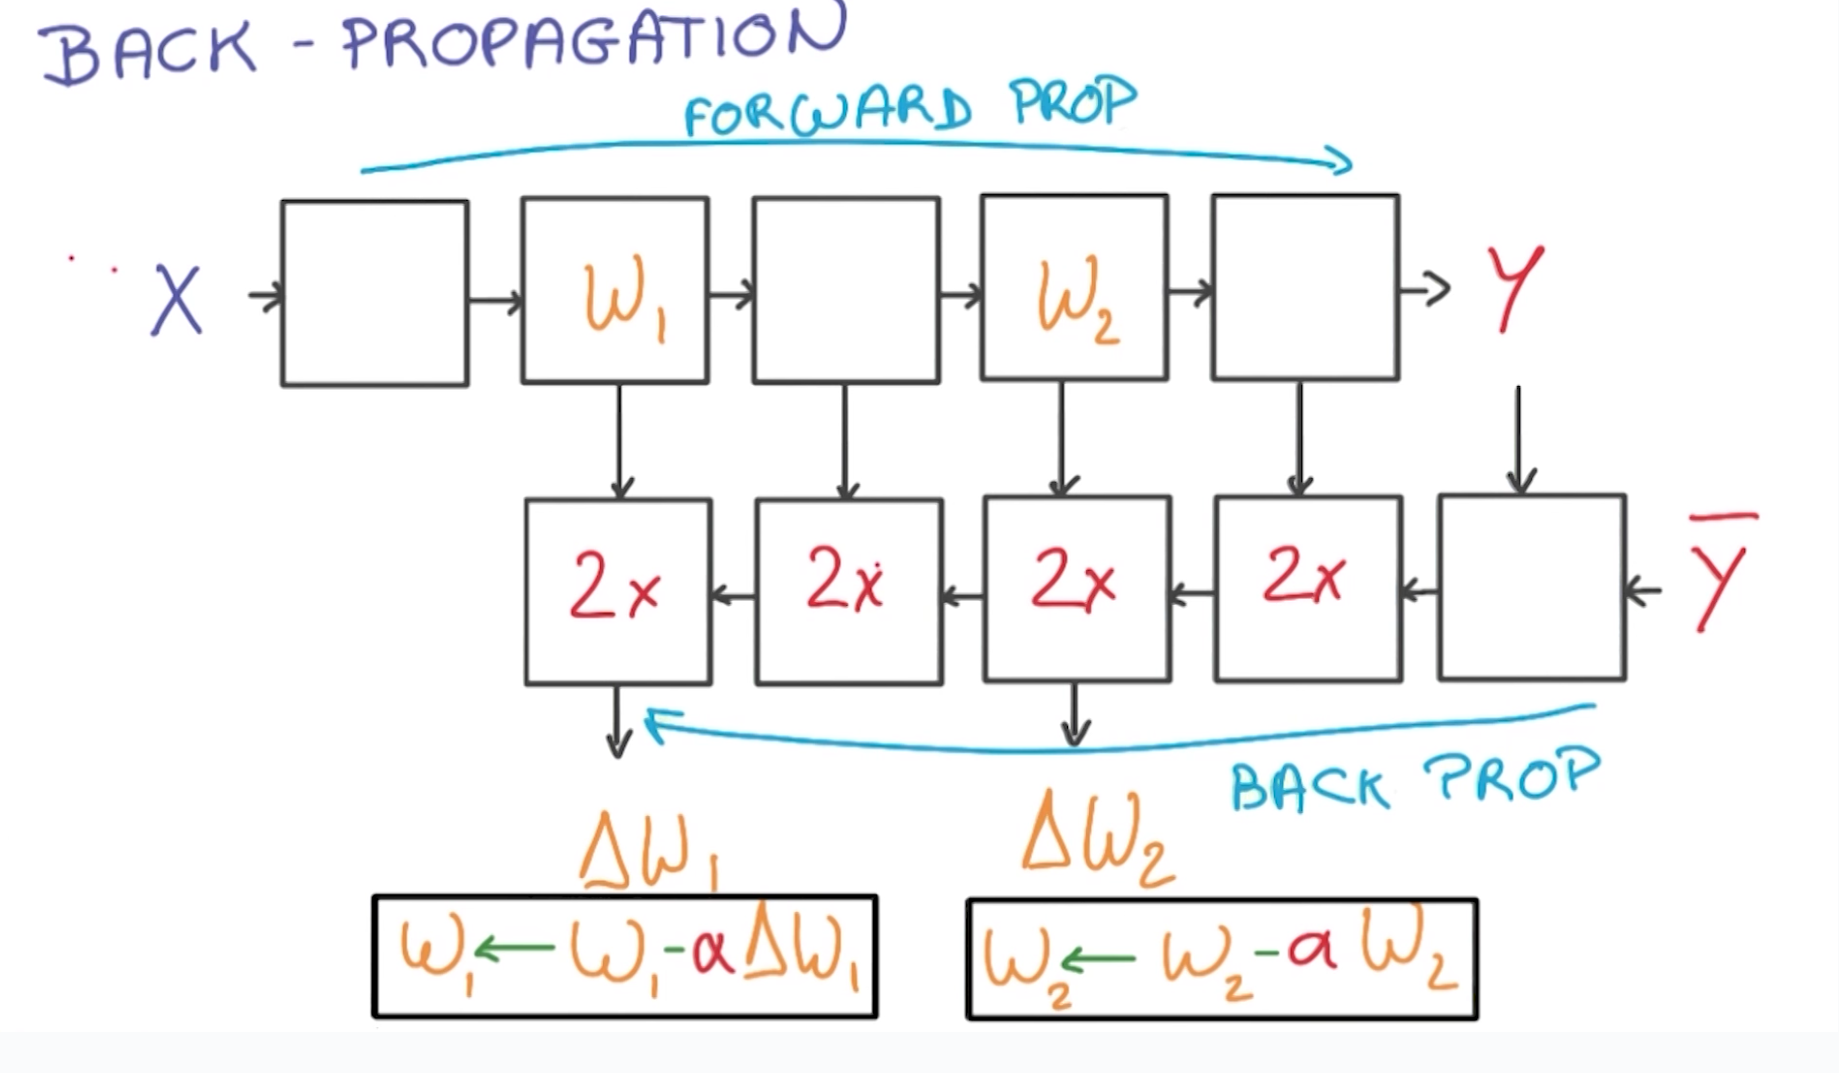

In [62]:
Image('/Users/gautamborgohain/PycharmProjects/DataScience/Neural Networks/Images/nn.png', retina=True)

In [66]:
batch_size = 128
img_size = 28
num_labels = 10

neurons = 1024

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    
    '''
    Adding a layer here
    '''
    weights1 = tf.Variable(tf.truncated_normal([img_size*img_size, neurons]))
    biases1 = tf.Variable(tf.truncated_normal([neurons]))
    
    weights2 = tf.Variable(tf.truncated_normal([neurons, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    
    syn0 = tf.nn.relu(tf.matmul(tf_train_dataset,weights1) + biases1)
    logits = tf.matmul(syn0,weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(loss)
    
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset,weights1) + biases1),weights2) + biases2)
    valid_predictions = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset,weights1) + biases1),weights2) + biases2)

In [75]:
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    scores = []
    for step in range(iters):
        '''
        Get data in batches
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        l,_,predictions,val_predictions = session.run([loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        pred_accuracy = accuracy(batch_labels,predictions)
        scores.append(pred_accuracy)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print('Minibatch Training Accuracy : ', pred_accuracy)
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  294.1
Minibatch Training Accuracy :  13.28125
Validation Accuracy :   10.99
Testing Accuracy :  20.25
Minibatch Loss at Step  100  :  82.1573
Minibatch Training Accuracy :  70.3125
Validation Accuracy :   69.87
Testing Accuracy :  78.13


** A cleaner implementation **

In [94]:
batch_size = 128
img_size = 28
num_labels = 10

neurons = 1024

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    
    def perceptron(train, _weights, _biases):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(train, _weights['w1']), _biases['b1']))
        return tf.matmul(layer_1, _weights['out']) + _biases['out']
    
    weights = {
        'w1': tf.Variable(tf.truncated_normal([img_size*img_size, neurons])),
        'out': tf.Variable(tf.random_normal([neurons, num_labels]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([neurons])),
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    logits = perceptron(tf_train_dataset,weights,biases)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(loss)
    
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(perceptron(tf_test_dataset,weights,biases))
    valid_predictions = tf.nn.softmax(perceptron(tf_valid_dataset,weights,biases))

In [95]:
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    scores = []
    for step in range(iters):
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        l,_,predictions,val_predictions = session.run([loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        pred_accuracy = accuracy(batch_labels,predictions)
        scores.append(pred_accuracy)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print('Minibatch Training Accuracy : ', pred_accuracy)
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  342.042
Minibatch Training Accuracy :  17.1875
Validation Accuracy :   24.85
Testing Accuracy :  34.79
Minibatch Loss at Step  100  :  80.1437
Minibatch Training Accuracy :  69.53125
Validation Accuracy :   71.35
Testing Accuracy :  75.31


---
# L2 regularization

---

In [97]:
batch_size = 128
img_size = 28
num_labels = 10
beta = 0.0005
neurons = 1024

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    
    def perceptron(train, _weights, _biases):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(train, _weights['w1']), _biases['b1']))
        return tf.matmul(layer_1, _weights['out']) + _biases['out']
    
    weights = {
        'w1': tf.Variable(tf.truncated_normal([img_size*img_size, neurons])),
        'out': tf.Variable(tf.random_normal([neurons, num_labels]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([neurons])),
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    logits = perceptron(tf_train_dataset,weights,biases)

#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    l2 = tf.nn.l2_loss(weights['w1'])
    l2 = l2 + tf.nn.l2_loss(weights['out'])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * l2
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(loss)
    
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(perceptron(tf_test_dataset,weights,biases))
    valid_predictions = tf.nn.softmax(perceptron(tf_valid_dataset,weights,biases))
    

In [98]:
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    scores = []
    for step in range(iters):
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        l,_,predictions,val_predictions = session.run([loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        pred_accuracy = accuracy(batch_labels,predictions)
        scores.append(pred_accuracy)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print('Minibatch Training Accuracy : ', pred_accuracy)
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  614.455
Minibatch Training Accuracy :  5.46875
Validation Accuracy :   26.53
Testing Accuracy :  38.08
Minibatch Loss at Step  100  :  236.265
Minibatch Training Accuracy :  71.875
Validation Accuracy :   69.94
Testing Accuracy :  76.67


# Learning rate decay

In [99]:
batch_size = 128
img_size = 28
num_labels = 10
beta = 0.0005
neurons = 1024

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    
    def perceptron(train, _weights, _biases):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(train, _weights['w1']), _biases['b1']))
        return tf.matmul(layer_1, _weights['out']) + _biases['out']
    
    weights = {
        'w1': tf.Variable(tf.truncated_normal([img_size*img_size, neurons])),
        'out': tf.Variable(tf.random_normal([neurons, num_labels]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([neurons])),
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    logits = perceptron(tf_train_dataset,weights,biases)

    l2 = tf.nn.l2_loss(weights['w1'])
    l2 = l2 + tf.nn.l2_loss(weights['out'])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * l2
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step,decay_steps = 1, decay_rate = 0.9999)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss,global_step=global_step)
    
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(perceptron(tf_test_dataset,weights,biases))
    valid_predictions = tf.nn.softmax(perceptron(tf_valid_dataset,weights,biases))
    
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    scores = []
    for step in range(iters):
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        l,_,predictions,val_predictions = session.run([loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        pred_accuracy = accuracy(batch_labels,predictions)
        scores.append(pred_accuracy)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print("Learning rate: " % learning_rate)
            print('Minibatch Training Accuracy : ', pred_accuracy)
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  492.499
Minibatch Training Accuracy :  10.15625
Validation Accuracy :   30.6
Testing Accuracy :  39.21
Minibatch Loss at Step  100  :  224.024
Minibatch Training Accuracy :  64.84375
Validation Accuracy :   71.91
Testing Accuracy :  76.78


# T0 DO-

Dropout and Tune learning rate for the 2 layer MLP

# Dropout

# Multilayer - 2D Neural network

In [86]:
batch_size = 128
img_size = 28
num_labels = 10

neurons = 1024

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(shape = (batch_size, img_size*img_size), dtype=tf.float32)
    tf_train_labels = tf.placeholder(shape = (batch_size, num_labels),dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset =  tf.constant(valid_dataset)
    
    def perceptron(train, _weights, _biases):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(train, _weights['w1']), _biases['b1']))
        layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['w2']), _biases['b2']))        # just added a layer
        return tf.matmul(layer_2, _weights['out']) + _biases['out']
    
    weights = {
        'w1': tf.Variable(tf.truncated_normal([img_size*img_size, neurons])),
        'w2': tf.Variable(tf.truncated_normal([neurons, neurons])),
        'out': tf.Variable(tf.random_normal([neurons, num_labels]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([neurons])),
        'b2': tf.Variable(tf.random_normal([neurons])),        
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    logits = perceptron(tf_train_dataset,weights,biases)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step,decay_steps = 1, decay_rate = 0.9999)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss,global_step=global_step)
    
    training_predictions = tf.nn.softmax(logits)
    testing_predictions = tf.nn.softmax(perceptron(tf_test_dataset,weights,biases))
    valid_predictions = tf.nn.softmax(perceptron(tf_valid_dataset,weights,biases))

In [87]:
iters = 200


with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    scores = []
    for step in range(iters):
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

        l,_,predictions,val_predictions = session.run([loss,optimizer,training_predictions,valid_predictions],feed_dict = feed_dict)
        pred_accuracy = accuracy(batch_labels,predictions)
        scores.append(pred_accuracy)
        if step %100 == 0:
            print('Minibatch Loss at Step ', step, ' : ', l)
            print('Minibatch Training Accuracy : ', pred_accuracy)
            print('Validation Accuracy :  ', accuracy(valid_labels,val_predictions))
            print('Testing Accuracy : ', accuracy(test_labels, testing_predictions.eval()))

Minibatch Loss at Step  0  :  5572.75
Minibatch Training Accuracy :  4.6875
Validation Accuracy :   14.94
Testing Accuracy :  12.1
Minibatch Loss at Step  100  :  nan
Minibatch Training Accuracy :  7.03125
Validation Accuracy :   10.0
Testing Accuracy :  10.0


In [1]:
'''

'''

'\n\n'